## Synchronization dynamics of Kuramoto oscillators

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys
import time

import torch
import torch.nn as nn
import torch.optim as optim

sys.path.append('../..')
from display import cm, format_axis, format_str, props
from ode import ODE, Kuramoto
from cxs import CXSGrid

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
default_type = torch.float64
torch.set_default_dtype(default_type)

In [3]:
image_dir = 'images/'
model_dir = 'models/'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Simulate time series data

In [4]:
method = 'dopri5'
adjoint = False

args = {'N': 80,
        'L': 2.,
        'v': 0,
        'K': 20.,
        's': 1.5
       }
M = 100

kuramoto = Kuramoto(args, method, default_type)
kuramoto.init_state(M)
kuramoto.to(device)

tf = 55
T = 2*tf + 1
t = torch.linspace(0, tf, T)
t0 = 10
T -= t0
print('T:', T)

kuramoto.solve(t, device=device)
kuramoto.trim(t0)

T: 101
Elapsed time: 5.57 s


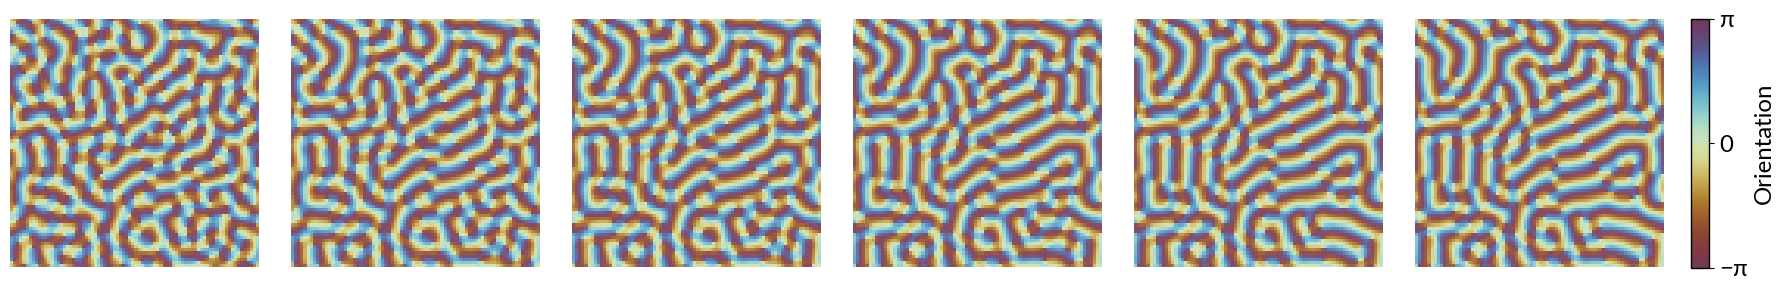

In [5]:
fig = kuramoto.plot_series(kuramoto.y[:,0].reshape(-1,kuramoto.N,kuramoto.N), ntype='mod', clabel='Orientation')

### Visualize speckle pattern

Detector: 56 x 56 	Probe: 7 x 7


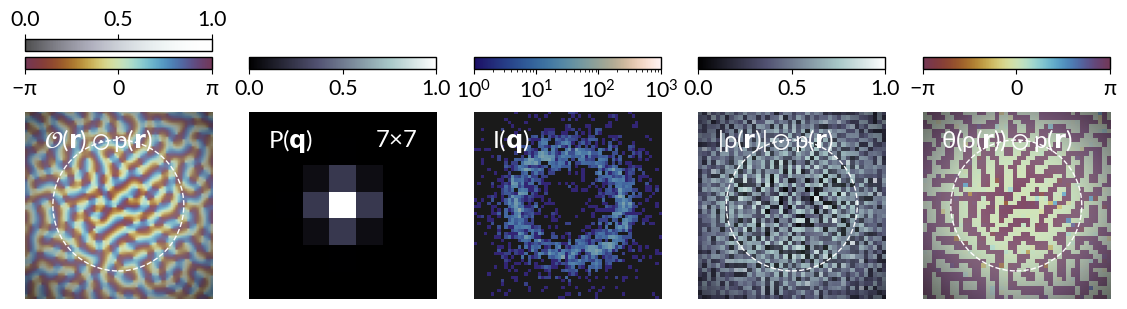

In [6]:
n = 42
dq = 0.75
f_probe = 0.35
f_mask = 0.06
eta = 10000
cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
cxs.shapes()
fig = cxs.plot_example(kuramoto, kuramoto.y0[0], ntype='mod', vmin=1e4, vmax=1e7, eta=eta)

In [7]:
batch_time = T - 1
batch_size = 1
t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch)
if eta: Y_batch = torch.poisson(Y_batch/eta)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([100])
y0: torch.Size([1, 1, 6400])
 y: torch.Size([100, 1, 1, 6400])
Elapsed time: 0.001 s


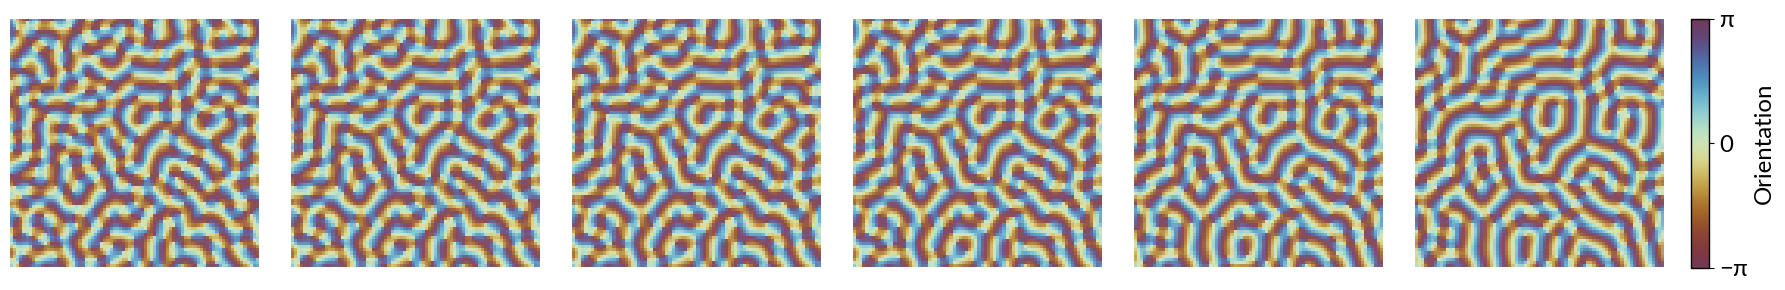

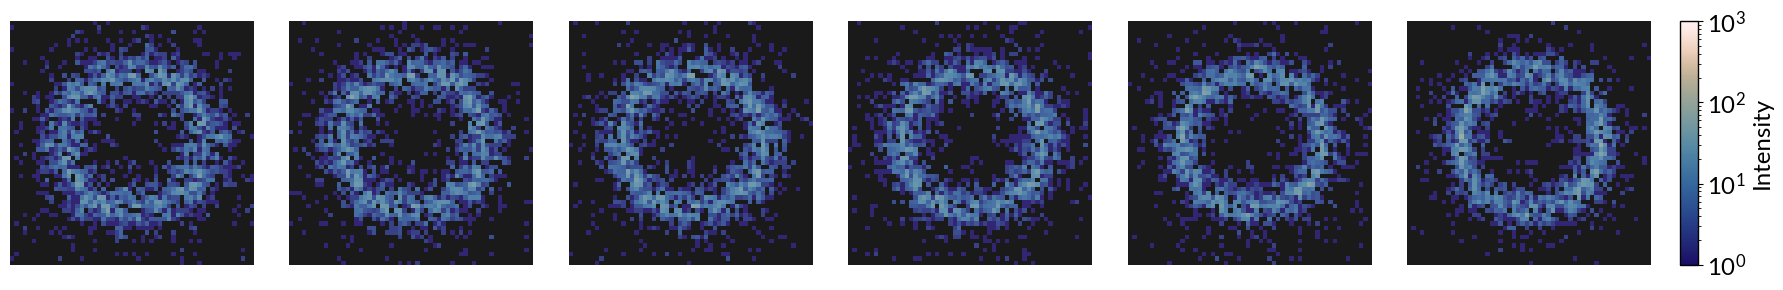

In [8]:
t_eval = kuramoto.get_eval(batch_time, n=6, d=5)

fig = kuramoto.plot_series(y_batch[t_eval,0].reshape(-1,kuramoto.N,kuramoto.N), ntype='mod', clabel='Orientation')
fig = kuramoto.plot_series(Y_batch[t_eval,0].reshape(-1,cxs.n,cxs.n), ntype='log',
                           vmin=1e4/(eta + float(eta == 0)), vmax=1e7/(eta + float(eta == 0)), clabel='Intensity')

### Define neural ODE model

In [9]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True, default_type=default_type)
        
        default_args = {'N': 100,
                        'L': 2.,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                        'eta': 0
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSGrid(self.N, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask, f='phase')
        
        self.conv = nn.Conv2d(1, 1, 11, bias=False, padding='same', padding_mode='circular')
        nn.init.normal_(self.conv.weight, mean=0, std=0.01)

                
    def loss(self, y_pred, y_true):
        if self.eta:
            return nn.L1Loss()(self.cxs(y_pred)/self.eta, torch.poisson(self.cxs(y_true)/self.eta))
        else:
            return nn.L1Loss()(self.cxs(y_pred), self.cxs(y_true))
        
   
    def forward(self, t, y):
        y = y.view((-1, 1, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        conv_cosy = self.conv(cosy)
        conv_siny = self.conv(siny)
        return (cosy*conv_siny - siny*conv_cosy).flatten(start_dim=-2)

In [10]:
method = 'dopri5'
adjoint = False

args = {'N': kuramoto.N,
        'L': kuramoto.L,
        'n': 42,
        'dq': 0.5,
        'f_probe': 0.25,
        'f_mask': 0.06,
        'eta': 0
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=5e-3)
print(node)

Detector: 84 x 84 	Probe: 13 x 13
NODE(
  (cxs): CXSGrid(
    (probe): Conv2d(1, 1, kernel_size=(42, 42), stride=(1, 1), padding=same, bias=False)
  )
  (conv): Conv2d(1, 1, kernel_size=(11, 11), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)


In [11]:
model_path = '_'.join(k.replace('_','') + format_str(v) for (k,v) in args.items())
model_path = model_dir + 'T' + str(T) + '_' + model_path + '.torch'
print(model_path)

models/T101_N80_L2p0_n42_dq0p5_fprobe0p25_fmask0p06_eta0.torch


### Train model

In [12]:
try: saved = torch.load(model_path)
except:
    chkpt = 5
    loss = []
    kernel = []
else:
    chkpt = saved['chkpt']
    loss = saved['loss']
    kernel = saved['kernel']
    node.load_state_dict(saved['state'])
    node.to(device)
    optimizer.load_state_dict(saved['optimizer'])

In [83]:
max_iters = 100
batch_time = 30
batch_size = 10
#optimizer.param_groups[0]['lr'] = 1e-5

end = time.time()
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_pred, y_batch)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            kernel.append(node.conv.weight.detach().squeeze().cpu())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end)) 
            
    end = time.time()

Iteration: 0005 | Total Loss: 0.857622 | Time: 1.376348
Iteration: 0010 | Total Loss: 0.857481 | Time: 1.317155
Iteration: 0015 | Total Loss: 0.870647 | Time: 1.383611
Iteration: 0020 | Total Loss: 0.886768 | Time: 1.353470
Iteration: 0025 | Total Loss: 0.890675 | Time: 1.448788
Iteration: 0030 | Total Loss: 0.899041 | Time: 1.383132
Iteration: 0035 | Total Loss: 0.881916 | Time: 1.353063
Iteration: 0040 | Total Loss: 0.908982 | Time: 1.389055
Iteration: 0045 | Total Loss: 0.819705 | Time: 1.301399
Iteration: 0050 | Total Loss: 0.853255 | Time: 1.356659
Iteration: 0055 | Total Loss: 0.894717 | Time: 1.357044
Iteration: 0060 | Total Loss: 0.879109 | Time: 1.356777
Iteration: 0065 | Total Loss: 0.846727 | Time: 1.327986
Iteration: 0070 | Total Loss: 0.848080 | Time: 1.357193
Iteration: 0075 | Total Loss: 0.881928 | Time: 1.385799
Iteration: 0080 | Total Loss: 0.857929 | Time: 1.327879
Iteration: 0085 | Total Loss: 0.851076 | Time: 1.362301
Iteration: 0090 | Total Loss: 0.867717 | Time: 1

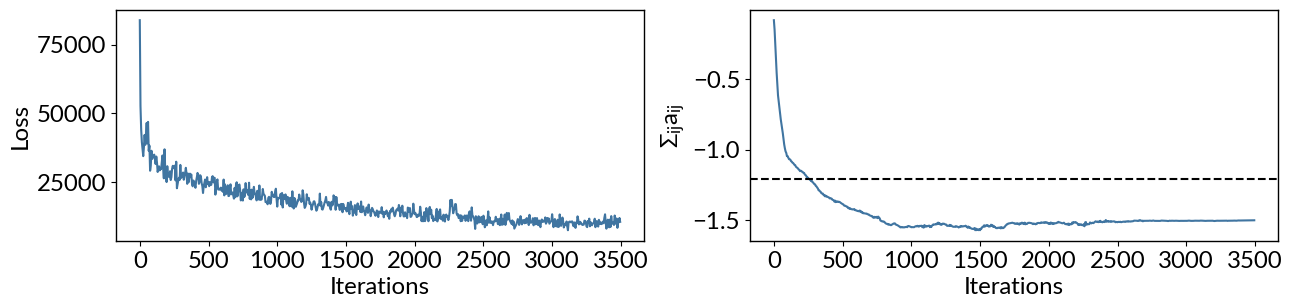

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,3))
ax[0].plot(chkpt*np.arange(len(loss)), loss, color=cm.lapaz(100))
#ax[0].set_yscale('log')
format_axis(ax[0], props, 'Iterations', 'Loss', ybins=4)

kernel_true = kuramoto.K*kuramoto.conv.weight.detach().squeeze().cpu()
ax[1].plot(chkpt*np.arange(len(loss)), [k.sum() for k in kernel], color=cm.lapaz(100))
ax[1].axhline(kernel_true.sum(), color='black', ls='dashed')
format_axis(ax[1], props, 'Iterations', r'$\Sigma_{ij} a_{ij}$', ybins=4)

In [44]:
torch.save({
    'state': node.state_dict(),
    'optimizer': optimizer.state_dict(),
    'chkpt': chkpt,
    'loss': loss,
    'kernel': kernel,
}, model_path)

### Evaluate model

In [14]:
batch_time = T - 1
t_eval = kuramoto.get_eval(batch_time, n=6, d=5)

with torch.no_grad():
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, 1)
    y_pred = node.solve(t_batch, y0_batch, device)
    
    if node.eta:
        Y_batch = torch.poisson(node.cxs(y_batch[t_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)/node.eta)
    else:
        Y_batch = node.cxs(y_batch[t_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)
    Y_pred = node.cxs(y_pred[t_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)/(float(node.eta==0) + node.eta)
    Y_diff = (Y_pred - Y_batch).reshape(-1,node.cxs.n,node.cxs.n)

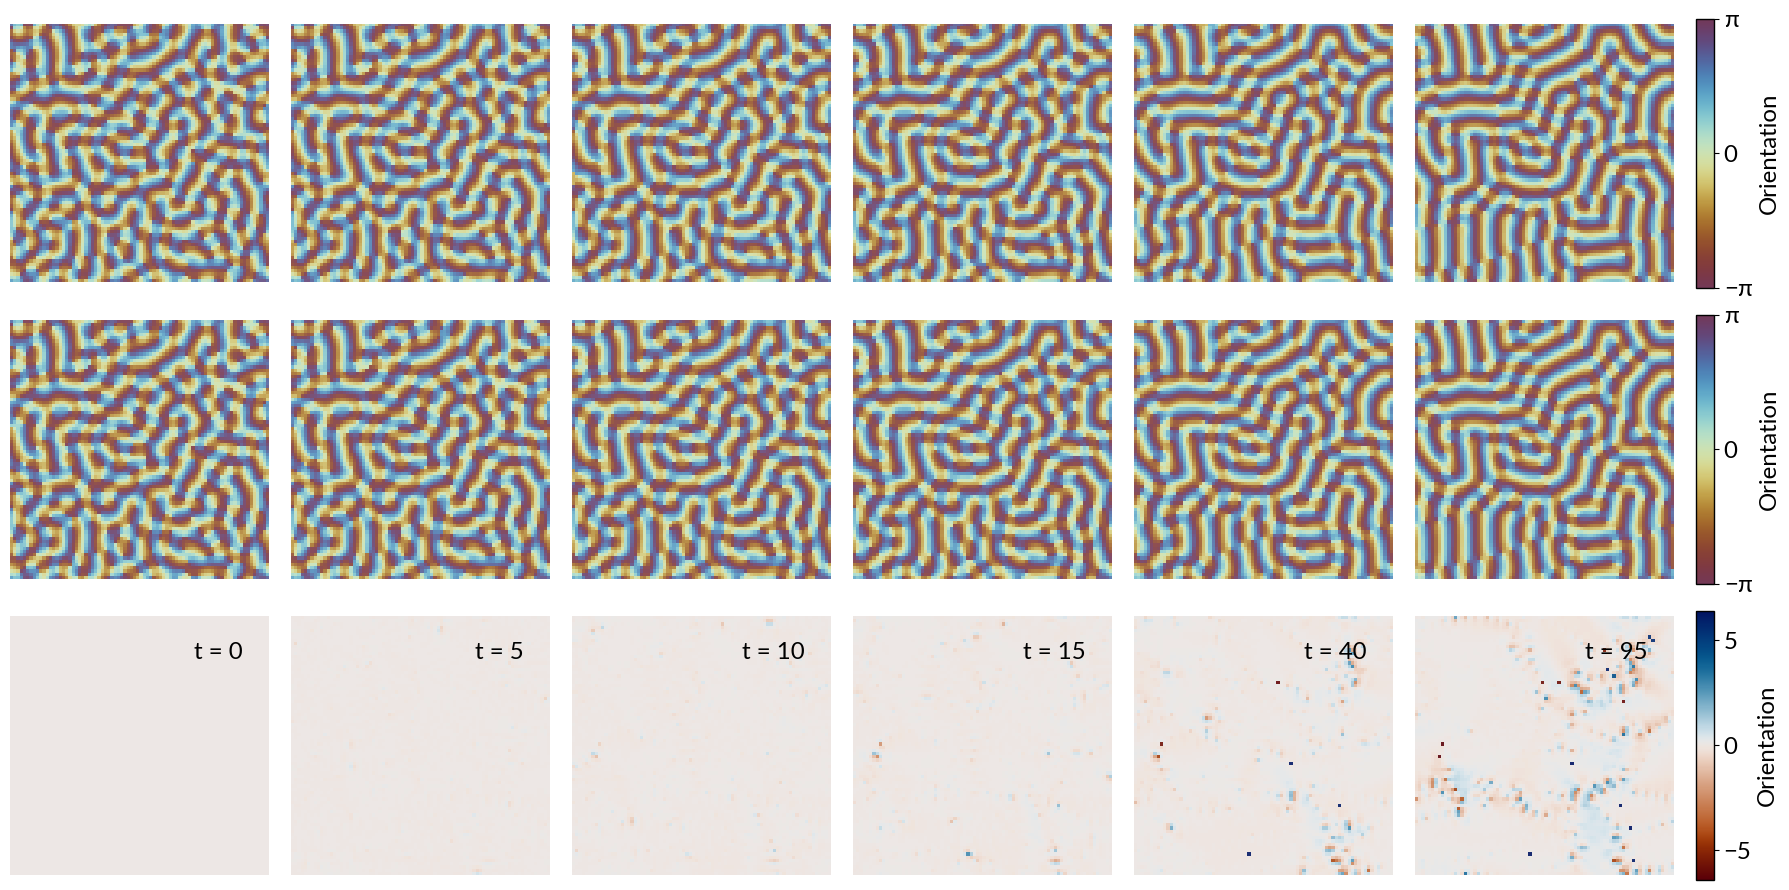

In [15]:
y_diff = y_pred[:,0] - y_batch[:,0]

fig = node.plot_series([y_batch[t_eval,0].reshape(-1,node.N,node.N),
                        y_pred[t_eval,0].reshape(-1,node.N,node.N),
                        y_diff[t_eval].reshape(-1,node.N,node.N)], ntype=['mod', 'mod', 'sym'], clabel='Orientation')

for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes)

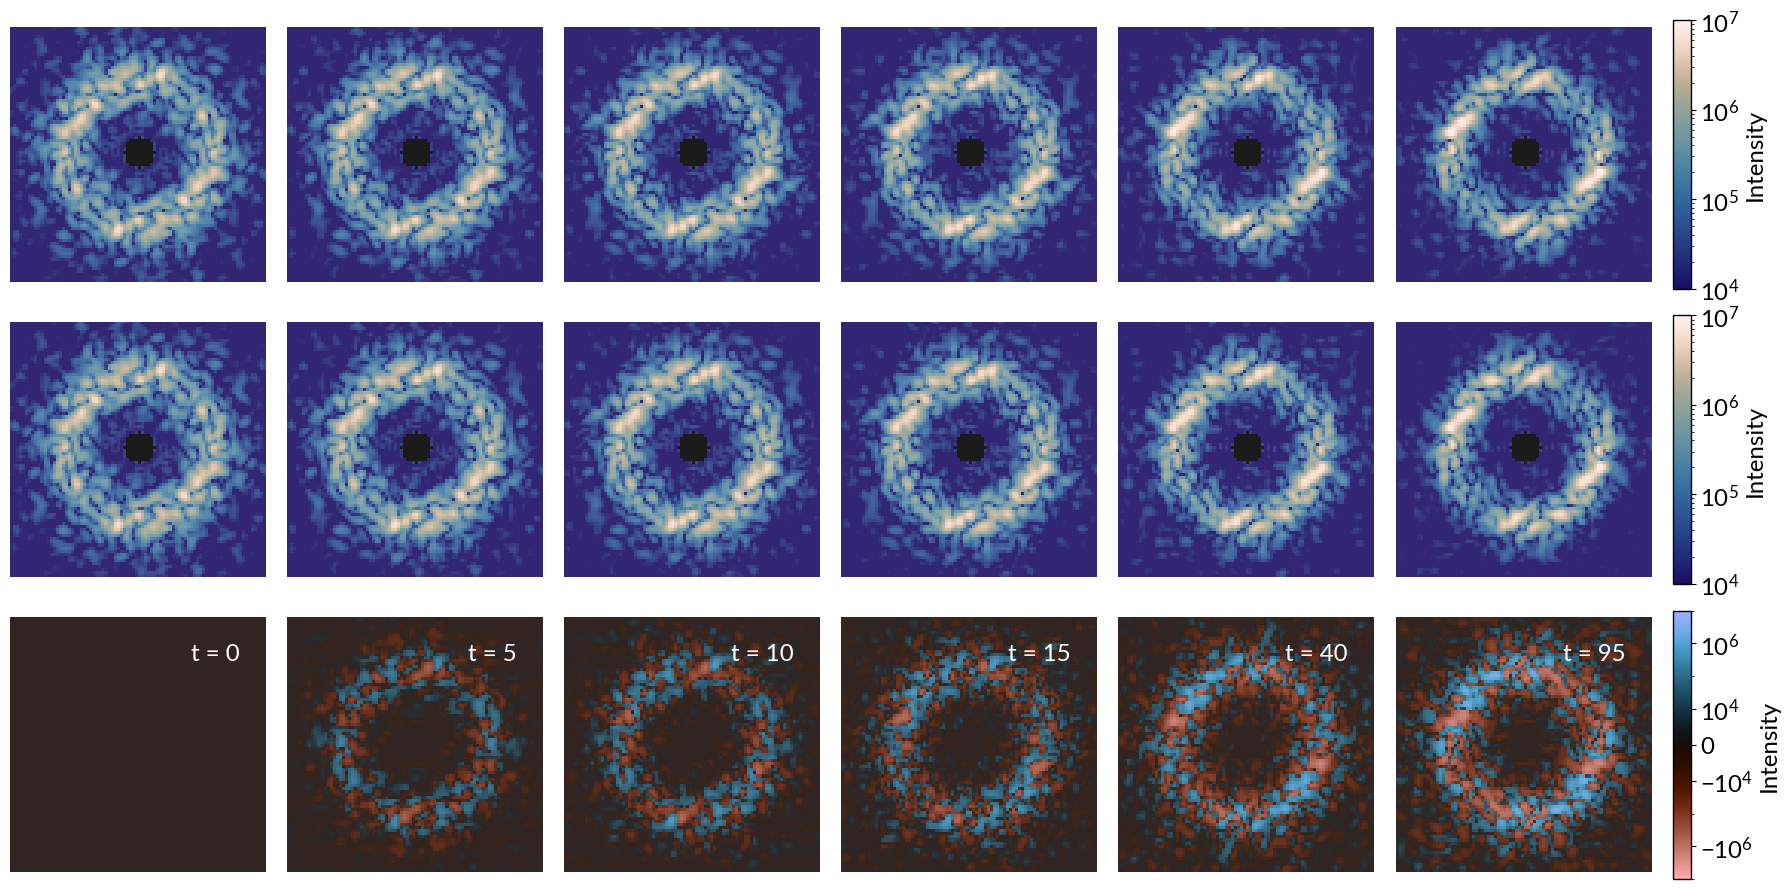

In [16]:
fig = node.plot_series([Y_batch, Y_pred, Y_diff], ntype=['log', 'log', 'symlog'], clabel='Intensity',
                       vmin=1e4/(float(node.eta==0) + node.eta), vmax=1e7/(float(node.eta==0) + node.eta))
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)

### Extrapolate model

In [17]:
M = 1

kuramoto.init_state(M)
kuramoto.to(device)

tf = 256
T = 2*tf + 1
t = torch.linspace(0, tf, T)
T -= t0
print('T:', T)

kuramoto.solve(t, device=device)
kuramoto.trim(t0)

T: 503
Elapsed time: 14.39 s


In [18]:
batch_time = T - 1
t_eval = kuramoto.get_eval(batch_time, n=6, d=10)

with torch.no_grad():
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, 1)
    y_pred = node.solve(t_batch, y0_batch, device)
    
    if node.eta:
        Y_batch = torch.poisson(node.cxs(y_batch[t_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)/node.eta)
    else:
        Y_batch = node.cxs(y_batch[t_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)
    Y_pred = node.cxs(y_pred[t_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)/(float(node.eta==0) + node.eta)
    Y_diff = (Y_pred - Y_batch).reshape(-1,node.cxs.n,node.cxs.n)

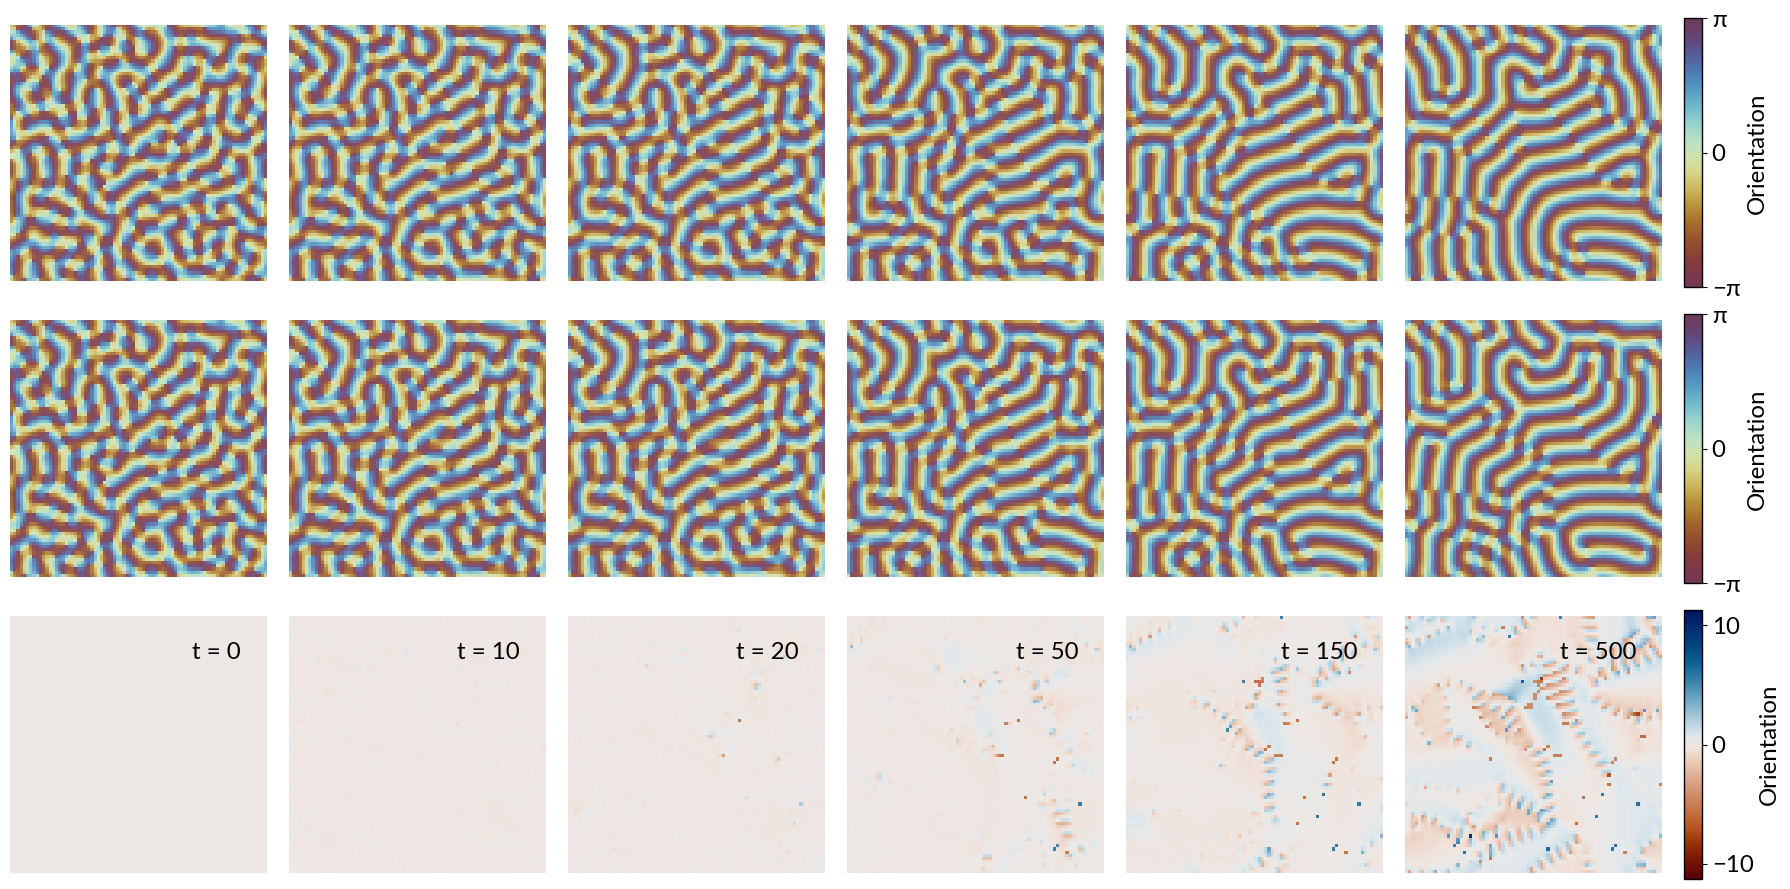

In [21]:
y_diff = y_pred[:,0] - y_batch[:,0]

fig = node.plot_series([y_batch[t_eval,0].reshape(-1,node.N,node.N),
                        y_pred[t_eval,0].reshape(-1,node.N,node.N),
                        y_diff[t_eval].reshape(-1,node.N,node.N)], ntype=['mod', 'mod', 'sym'], clabel='Orientation')

for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_dir + 'kuramoto_real.png', dpi=400, bbox_inches='tight')

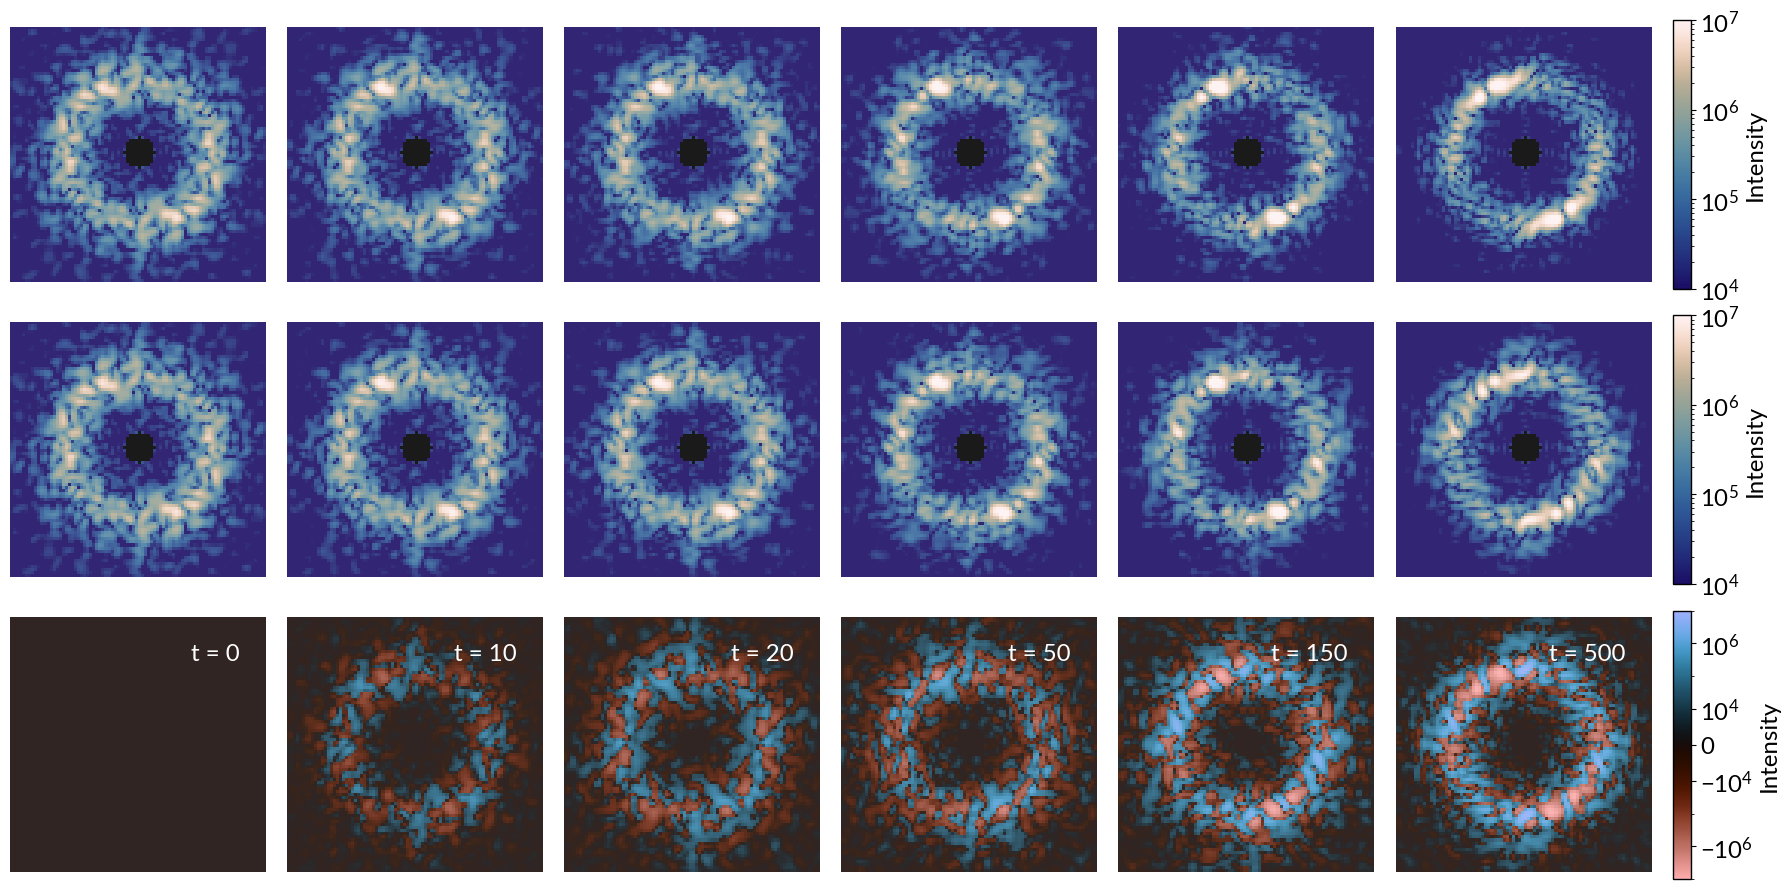

In [22]:
fig = node.plot_series([Y_batch, Y_pred, Y_diff], ntype=['log', 'log', 'symlog'], clabel='Intensity',
                       vmin=1e4/(float(node.eta==0) + node.eta), vmax=1e7/(float(node.eta==0) + node.eta))
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_dir + 'kuramoto_fourier.png', dpi=400, bbox_inches='tight')